# Lập trình thống kê cơ bản với Python
# Bài 7: Tự code thủ công kiểm định t cho 2 mẫu độc lập

### BS. Lê Ngọc Khả Nhi

# Nhập đề:

Kiểm định t được William Sealy Gosset thiết kế vào năm 1908 dưới bút danh là Student, công dụng của nó để so sánh giá trị trung bình giữa 2 phân nhóm độc lập dựa vào một phản nghiệm trên trị số thống kê đại diện tên là t. 

Trong bài này, Nhi hướng dẫn các bạn code thủ công một kiểm định t bằng Python hướng đối tượng (OOP).

Mục tiêu của chúng ta là tạo ra 1 class cho phép thực hiện kiểm định t để so sánh biến kết quả Y giữa 2 phân nhóm G1,G2. Class này nhận dữ liệu đầu vào là 1 dataframe, công thức có nội dung 'Y ~ G' và ngưỡng alpha; nếu G có 2 giá trị, sẽ thực hiện kiểm định t so sánh trung bình Y(G1) và Y(G2). Kết quả xuất ra bao gồm t statistics, độ tự do, giá trị p, kết luận phủ định hay không giả thuyết H0, và 3 trị số effect size gồm Rosenthal's r, Hedge's G và Cohen's d.

# Tạo class Ind_samples_t

In [1]:
class Ind_samples_t():
    '''Class kiểm định t cho 2 mẫu độc lập
    @ Input: 
    data : pandas dataframe
    form = công thức dạng 'Y~X'
    Chú ý: nếu X có nhiều hơn 2 bậc, chỉ xét 2 bậc đầu tiên
    alpha = ngưỡng ý nghĩa, mặc định = 0.05
    @ Output:
    1 bảng tóm tắt kết quả
    2 hình vẽ
    
    '''
    def __init__(self, data, form, alpha = 0.05):
        
        # Khởi tạo class
        self.data = data
        self.form = form
        self.alpha = alpha
        
        # Tạo design matrix bằng patsy
        Y, X = dmatrices(self.form + '-1', 
                 data=self.data,
                 return_type='dataframe')
        
        if X.shape[1] > 2:
            print('Biến phân nhóm có nhiều hơn 2 bậc giá trị\ntest được thực hiện trên 2 bậc đầu tiên')
        
        y1, y2 = Y[X.iloc[:,0]== 1].values.flatten(), \
                     Y[X.iloc[:,1]== 1].values.flatten()
        
        # Tính t 
        mu_1, mu_2 = y1.mean(), y2.mean()
        n1, n2 = len(y1), len(y2)
        std1, std2 = np.std(y1, ddof=1), np.std(y2, ddof=1)
        se1, se2 = std1/sqrt(n1), std2/sqrt(n2)
        sed = sqrt(se1**2.0 + se2**2.0)
        t_stat = (mu_2 - mu_1) / sed

        df = n1 + n2 - 2
        
        # Tính p value
        p = (1 - t.cdf(abs(t_stat), df)) * 2
        
        # Tính effect-size
        r = sqrt(t_stat**2 / (t_stat**2 + df))
        d1 = np.abs(mu_1 - mu_2)/np.std(y1, ddof=1)
        d2 = np.abs(mu_2 - mu_1)/np.std(y2, ddof=1)
        g1= d1*(1- (3/(4*(n1+n2)-9)))
        g2= d2*(1- (3/(4*(n1+n2)-9)))
        
        # Giải nghĩa kết quả
        h0 = 'Có' if p < self.alpha else 'Không'
        
        # Đóng gói kết quả
        self._ttest = {'Y':(y1,y2), 
                           'X':(X.columns[0], X.columns[1]),
                          'Mean':(mu_1, mu_2),
                           'n':(n1,n2),
                           'std':(std1,std2),
                           'se':(se1,se2),
                           'sed':sed,
                           't_stat':t_stat,
                           'dof':df,
                           'p':p,
                           'cohen':(d1,d2),
                           'r':r,
                           'g':(g1,g2),
                           'h0': h0,
                          }                    

    def summary(self):
        '''
        Hàm tạo bảng kết quả và vẽ hình
        '''
        # Tạo bảng kết quả
        
        out = pd.DataFrame({'Nhóm': self._ttest['X'],
                  'Cỡ mẫu': self._ttest['n'],
                  'Trung bình': self._ttest['Mean'],
                  'Giá trị t': (self._ttest['t_stat'],' '),
                  'Độ tự do': (self._ttest['dof'],' '),
                  'Giá trị p': (self._ttest['p'],' '),
                  'Kích thước hiệu ứng': ['','',],
                  'Rosenthal\'s r': (self._ttest['r'],' '),
                  'Cohen\'s d': self._ttest['cohen'],
                  'Hedge\'s G': self._ttest['g'],
                  'Phủ nhận H0': (self._ttest['h0'],' '),
                 })

        out.index = [''] * len(out.index)
        
        # Vẽ hình
        h0 = t(df=self._ttest['dof'])
        h1 = self._ttest['t_stat']

        samp = np.linspace(h1-2,h1+5,100) if h1 < 0 else np.linspace(h1-5,h1+2,100)
        
        plt.plot(samp, h0.pdf(samp), color = 'red')

        plt.axvline(x=h1, ymin=0.1, ymax=h0.pdf(h1)+0.01, color='darkred')
        plt.text(h1,h0.pdf(h1),"H1")

        pv = np.linspace(h1,h1+2,50) if h1>0 else np.linspace(h1-2,h1,50)
        plt.fill_between(pv, h0.pdf(pv), facecolor='red', alpha = 0.3)
        plt.xlabel('Giá trị t')

        plt.figure()
        ax1 = sns.kdeplot(pd.Series(self._ttest['Y'][0], name = self._ttest['X'][0]), shade = True, color = 'red')
        ax2 = sns.kdeplot(pd.Series(self._ttest['Y'][1], name = self._ttest['X'][1]), shade =True, color = 'blue')
        ax1.axvline(self._ttest['Mean'][0], color ='red', linestyle='dashed', linewidth=1.5)
        ax2.axvline(self._ttest['Mean'][1], color ='blue', linestyle='dashed', linewidth=1.5)
        plt.legend()
        plt.xlabel(self.form.split('~')[0].strip())

        return out.T

# Sử dụng class Ind_samples_t

Trước tiên ta tải 1 số thư viện cần thiết và chuẩn bị 1 dataframe dữ liệu

In [2]:
import pandas as pd
from patsy import dmatrices
from math import sqrt
import numpy as np

from scipy.stats import sem
from scipy.stats import t
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("https://raw.githubusercontent.com/kinokoberuji/R-Tutorials/master/aerodim.csv",sep=";")

In [15]:
data.head()

,Poids,Taille,BMI,Age,Sexe,Hb,Diagnostic,GST,Volume,Surface,DmCO,Thickness,DLCO,FVC
0,53,165,19.467401,54,F,13.4,E,1.284048,7.0080,19.647869,450.315872,0.142701,6.767,2.30
1,92,170,31.833910,75,H,17.1,E,1.291861,3.7750,10.519710,72.271882,0.476060,19.146,3.04
2,69,186,19.944502,41,H,14.6,E,1.211214,7.7695,23.092705,372.142895,0.202952,29.047,5.72
3,60,160,23.437500,75,F,13.5,E,1.439790,4.3295,10.825326,89.206177,0.396893,14.943,2.57
4,72,172,24.337480,60,H,14.6,E,1.388885,5.5610,14.414152,180.833030,0.260699,13.888,4.36


Do biến Diagnostic có 3 bậc giá trị, class sẽ hiện thông báo rằng chỉ có 2 bậc đầu tiên được xét trong test t:

In [3]:
t1 = Ind_samples_t(data=data,form = 'Surface~Diagnostic')

Biến phân nhóm có nhiều hơn 2 bậc giá trị
test được thực hiện trên 2 bậc đầu tiên


,,
Nhóm,Diagnostic[E],Diagnostic[F]
Cỡ mẫu,14,9
Trung bình,16.4449,36.394
Giá trị t,3.29805,
Độ tự do,21,
Giá trị p,0.00342538,
Kích thước hiệu ứng,,
Rosenthal's r,0.584141,
Cohen's d,3.16586,1.14461
Hedge's G,3.05143,1.10324


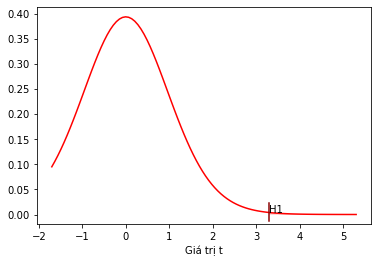

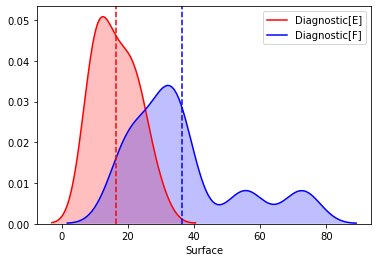

In [4]:
t1.summary()

Sau khi loại bỏ 1 bậc giá trị, thí dụ F, ta có t test hoàn hảo:

,,
Nhóm,Diagnostic[E],Diagnostic[N]
Cỡ mẫu,14,15
Trung bình,16.4449,46.0498
Giá trị t,6.00746,
Độ tự do,27,
Giá trị p,2.07447e-06,
Kích thước hiệu ứng,,
Rosenthal's r,0.756331,
Cohen's d,4.69819,1.65049
Hedge's G,4.56647,1.60421


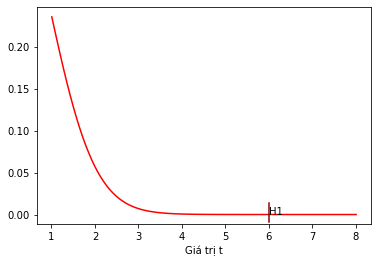

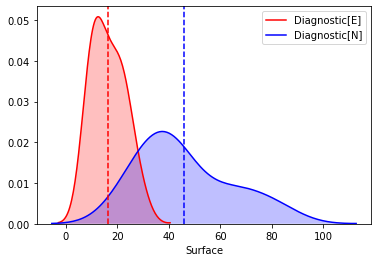

In [5]:
data = data[data['Diagnostic'] != 'F']

t2 = Ind_samples_t(data=data,form = 'Surface~Diagnostic')

t2.summary()

Một trường hợp có kết quả negative:

,,
Nhóm,Sexe[F],Sexe[H]
Cỡ mẫu,12,17
Trung bình,23.0727,20.0007
Giá trị t,-0.853641,
Độ tự do,27,
Giá trị p,0.400814,
Kích thước hiệu ứng,,
Rosenthal's r,0.16211,
Cohen's d,0.311221,0.338973
Hedge's G,0.302495,0.329469


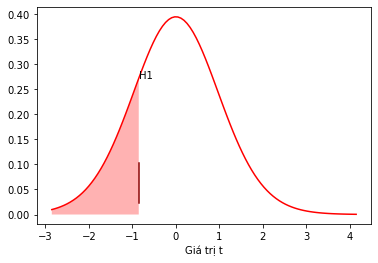

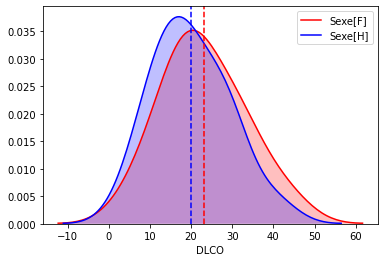

In [6]:
t3 = Ind_samples_t(data=data,form = 'DLCO~Sexe')

t3.summary()

Một trường hợp khác : biến FVC

,,
Nhóm,Diagnostic[E],Diagnostic[N]
Cỡ mẫu,13,15
Trung bình,3.66538,4.93753
Giá trị t,3.23355,
Độ tự do,26,
Giá trị p,0.00331484,
Kích thước hiệu ứng,,
Rosenthal's r,0.535545,
Cohen's d,1.16063,1.31528
Hedge's G,1.12683,1.27697


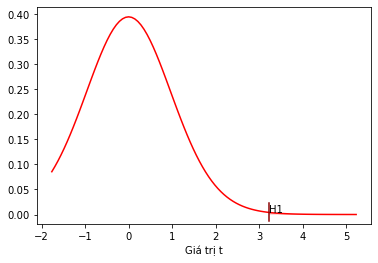

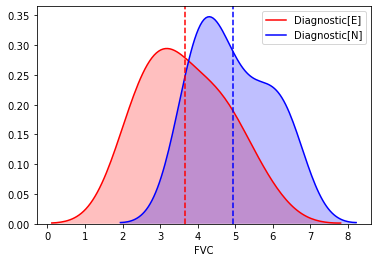

In [7]:
t4 = Ind_samples_t(data=data,form = 'FVC ~ Diagnostic')

t4.summary()

Biến DmCO

,,
Nhóm,Diagnostic[E],Diagnostic[N]
Cỡ mẫu,14,15
Trung bình,220.123,257.264
Giá trị t,0.787451,
Độ tự do,27,
Giá trị p,0.437876,
Kích thước hiệu ứng,,
Rosenthal's r,0.149834,
Cohen's d,0.251862,0.370114
Hedge's G,0.2448,0.359737


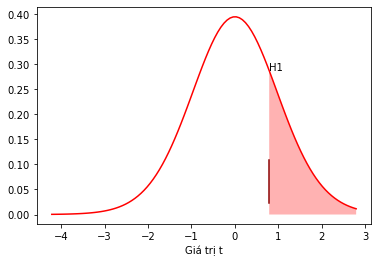

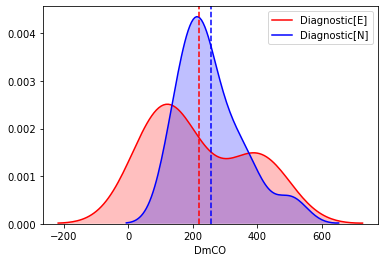

In [8]:
t5 = Ind_samples_t(data=data,form = 'DmCO~ Diagnostic')

t5.summary()

In [ ]:
Bài thực hành tạm dừng, hẹn gặp lại các bạn lần sau.